# Weather vs Call Volume

The purpose of this exploration is to understand how call volume spikes in certain hours, and what 
causes it. This notebook is a cleaner retelling of the exploration that spans multiple notebooks.
You can see the raw unedited explorations in the `notebooks/exploratory` folder, if you dare. This one is much easier to understand.

## The Ambient Temperature Clue

When I first started with this dataset I heard a rumor. I heard that ambient temperature was used in another major metropolitan area. According to my source, the ambient temperature alters the social behavior of a population when it reaches a certain range. 

I was curious if this trend could be observed in the San Francisco 911 call records. And so I began.

***

The path to actually find a database of temperature that was both detailed enough and also covered a healthy enough range of dates was harder than I anticipated. I'll skip this part of the journey, with just a summary that I looked at a number of APIs that provided weather data. Even when I decided on using the data from NOAA, it took some time to understand the differences between the handful of stations reporting weather information. One of the interesting parts was seeing where the stations were actually located, which seemed to encircle the city, but not actually provide data from inside.

There were two important outcomes of this initial ambient temperature exploration. First, the fact that the temperature data was an hourly measurement compelled me to group the call records by hour. Second, there was not a readily-available relationship between temperature and quantity of calls or type of calls, although there are still plenty of things to look at.

The first lesson is key though, because after grouping the data by the hour, I began cleaning it and looking for problems and also outliers. Outliers are great because they usually point to a step you forgot to add in your munging and cleaning steps of your pipeline, but sometimes also give clues about bright spots and trends in your data.

Let's load the data and the libraries and look at the distribution of number of calls by hour.

In [2]:
from __future__ import division, print_function
import json
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
query_url = 'https://data.sfgov.org/resource/wbb6-uh78.json?$order=close_dttm%20DESC&$offset={}&$limit={}'
offset = 0
limit = 100000
fdf = pd.read_json(query_url.format(offset, limit))

In [4]:
def clean_fire_data(df):
    cols_to_drop = ["automatic_extinguishing_sytem_failure_reason",
                "automatic_extinguishing_sytem_type",
                "battalion",
                "box",
                "call_number",
                "detector_effectiveness",
                "detector_failure_reason",
                "ems_personnel",
                "ems_units",
                "exposure_number",
                "first_unit_on_scene",
                "ignition_factor_secondary",
                "mutual_aid",
                "no_flame_spead",
                "other_personnel",
                "other_units",
                "station_area",
                "supervisor_district"]
    df = df.drop(cols_to_drop, axis=1)
    for col in df.columns:
        if 'dttm' in col:
            df[col] = pd.to_datetime(df[col])
    return df

In [5]:
fdf = clean_fire_data(fdf)

In [6]:
# we'll make a Series where the incidents are grouped by hour
gdf = fdf.rename(columns={'alarm_dttm':'dttm'}).set_index('dttm').groupby(pd.TimeGrouper('H')).count()['incident_number']

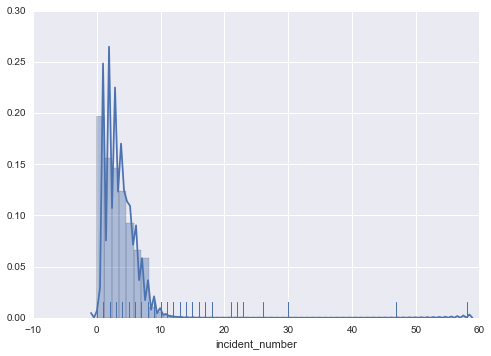

In [7]:
sns.distplot(gdf, hist=True, rug=True);

When I look at distributions, I really appreciate the ability for Seaborn to overlay the kernel density estimate as well as the rug plot, because it makes it much easier to see outliers that may not otherwise appear. In this case the histogram would have missed it, but the cluster of data points above 55 was sufficient enough in quantity to even cause the line of the KDE to ripple a bit. However, the KDE and histogram would have missed the single data point that appears to have about 48 incident numbers reported in a single hour.

Another way of quickly checking this sort of data is to use the describe function, which we'll do now in order to not only verify the numerical values of our biggest outliers, but also pull up those specific records so we can see what the heck is going on. At this point it's unclear whether we are dealing with an error in the data, or a valid data point.

In [8]:
gdf.describe()

count    29879.000000
mean         3.346832
std          2.327126
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         58.000000
Name: incident_number, dtype: float64

In the above, you'll see the mean is at 3.3 incidents per hour, the median at 3 incident per hour, and a standard deviation of 2.3 incidents. That suggests that the maximimum value in this Series of 58 incidents reported in a single hour is over 20 standard deviations above the mean. At this point I was willing to bet money that this was an error. Often times when a dataset is created, especially with excel and .csv files, someone adds a row that represents the total or some other aggregate of all the other datapoints. When I first saw this I thought that was what we were seeing. Let's take a closer look. I am lazy, so to save time I like to use the max() function to quickly reference the maximum value datapoint. We will also reset the index so that we can use the datettime field and treat this as a dataframe, because it's fun to do.

In [9]:
# I'll break out the mask so it's easier to understand
# the mask will filter for only records where the incident_number (count) == the max value of the dataset
mask = (gdf.reset_index().incident_number == (gdf.max()))
gdf.reset_index()[mask]

,dttm,incident_number
15296,2014-12-11 07:00:00,58


OK, so is this an error? How can we tell? Well, we can go back to the original dataframe, and look at the date in question. What was going on during the hour of 7 am that got everyone so excited? Or, is this some weird error? Let's take a look at the types of incidents that were recorded during that time frame.

In [10]:
# fdf[fdf.alarm_dttm >= gdf.reset_index()[mask]['dttm']]
strange_dttm = gdf.reset_index()[(gdf.reset_index().incident_number == (gdf.max()))]['dttm'].iloc[0]
# this will give us a temporary frame including only those calls during the hour it should be 58 records long
temp_df = fdf[(fdf.alarm_dttm >= strange_dttm) & (fdf.alarm_dttm <= strange_dttm + pd.tslib.Timedelta(hours=1))]
temp_df.shape

(58, 44)

Now that we have a dataframe that represents each individual call that comprised our outlier, let's look at what kind of calls we had coming in that hour, shall we?

In [11]:
temp_df.primary_situation.value_counts(dropna=False)

353 removal of victim(s) from stalled elevator          10
745 alarm system activation, no fire - unintentional     9
730 system malfunction, other                            5
440 electrical  wiring/equipment problem, other          5
444 power line down                                      5
740 unintentional transmission of alarm, other           3
735 alarm system sounded due to malfunction              3
520 water problem, other                                 3
550 public service assistance, other                     2
700 false alarm or false call, other                     2
500 service call, other                                  2
151 outside rubbish, trash or waste fire                 1
445 arcing, shorted electrical equipment                 1
800 severe weather or natural disaster, other            1
711 municipal alarm system, malicious false alarm        1
652 steam, vapor, fog or dust thought to be smoke        1
400 hazardous condition, other                          

### WTF

What the heck was going on? In a dataset where the average number of calls per hour was 2-3, we suddenly have ten calls in a single hour exclusively about removing victims from a stalled elevator! Is this a single building? Let's see....

In [12]:
temp_df[temp_df.primary_situation == temp_df.primary_situation.value_counts(dropna=False).index[0]].address.value_counts(dropna=False)

2001 Van Ness Avenue    2
818 Van Ness Avenue     1
965 Sutter St 6th Fl    1
415 Ofarrell Street     1
654 Grove Street        1
2001 Pierce Street      1
301 Pine Street         1
430 Turk Street         1
1770 Pacific Av 2nd     1
Name: address, dtype: int64

Huh. OK, so this was not the case of one giant elevator and ten people with cell phones calling 911 because somebody cut the cheese. Multiple buildings in a single hour had the need to call the SFFD for an elevator rescue. 

Looking at the above data of the various primary situation recods, can you guess yet what the cause of this spike was?

Let me show you what a quick Google search for news on that date revealed...


## HEADLINE: Rainstorm Turns the San Francisco Area From Arid to Soggy in Hours


You can read about it [here](http://www.nytimes.com/2014/12/12/us/california-storm-pineapple-express-san-francisco-braces.html?_r=0)

![pic of kids enjoying Dec 2014 flood](http://www.gannett-cdn.com/-mm-/7eb5ee01dc0b674cc6d0f0472270b998bc23b36b/c=252-0-3542-2474&r=x513&c=680x510/local/-/media/2014/12/11/DetroitNews/DetroitNews/635539103606182231-storms010.JPG)

***

I always knew that Californians couldn't drive in the rain. Apparently we can't elevator in the rain either... Joking aside, this isn't the first time the emergency services of San Francisco have been overburdened by wet weather. Further exploration into looking at the outliers in the dataset show another storm that happened a couple months later that also caused a major spike in emergency services demand. Power lines, electrical wiring issues, and severe weather or natural disaster calls appear to be a burden on our city services.

A quick Google search for "February 06 2015 Power" reveals [this news](http://sanfrancisco.cbslocal.com/2015/02/06/55000-lose-power-during-bay-area-storm-thousands-remain-in-the-dark-pge-east-bay-north-bay-peninsula-south-bay-san-francisco/) story:

> Nearly 15,000 PG&E customers in the Bay Area were without power Friday afternoon because of the high winds and rain passing through the area, PG&E officials said.

![Image of downed tree](https://pbs.twimg.com/media/B9MpHOCCIAAOW81.jpg:medium)


***

### Outliers 

There are a couple of ways you can look at the highest values of your data. One simple way is sort the grouped by hour Series and then looking at each data point starting from the highest to the lowest. 

Another way is to look at all of your outliers. This latter method is probably smarter because you want to see if there are still errors hidden in your data. Normally I'm a big fan of outliers and would go this direction, but I'm lazy and will save that for a separate post.

So let's get lazy and look at the sorted list of the highest alues in our Series.

In [13]:
gdf.sort_values(ascending=False).head(10)

dttm
2014-12-11 07:00:00    58
2014-12-03 03:00:00    47
2014-12-11 08:00:00    30
2014-12-30 17:00:00    30
2016-03-05 20:00:00    26
2015-12-13 09:00:00    23
2014-12-30 16:00:00    23
2015-02-06 18:00:00    22
2014-12-11 10:00:00    21
2014-12-11 09:00:00    18
Name: incident_number, dtype: int64

In the above sample of top 10 hours in terms of call volume, December 11 clearly was a popular morning. What's left if we filter those out? In that same month in 2014, there was a spike on December 3, and also on December 30. Then later in 2015 a spike on February 6 2015 as was pictured above. More recently, there was a spike on March 5 2016. Just for fun let's take a quick look at these new dates to see if there's anything interesting there.

In [14]:
for weirdo in gdf.sort_values(ascending=False).head(10).index:
    # we'll skip December 11, we know what happened there
    print("\n{}".format(weirdo))
    temp_df = fdf[(fdf.alarm_dttm >= weirdo) & (fdf.alarm_dttm <= weirdo + pd.tslib.Timedelta(hours=1))]
    print(temp_df.primary_situation.value_counts(dropna=False))


2014-12-11 07:00:00
353 removal of victim(s) from stalled elevator          10
745 alarm system activation, no fire - unintentional     9
730 system malfunction, other                            5
440 electrical  wiring/equipment problem, other          5
444 power line down                                      5
740 unintentional transmission of alarm, other           3
735 alarm system sounded due to malfunction              3
520 water problem, other                                 3
550 public service assistance, other                     2
700 false alarm or false call, other                     2
500 service call, other                                  2
151 outside rubbish, trash or waste fire                 1
445 arcing, shorted electrical equipment                 1
800 severe weather or natural disaster, other            1
711 municipal alarm system, malicious false alarm        1
652 steam, vapor, fog or dust thought to be smoke        1
400 hazardous condition, other     

As you can see these are mostly alarm system malfunctions or calls related to the issue of severe weather.

## Where we go from here

There are a number of next steps to take here. First of all, it is worth a conversation with the city to see if there might be a way to make this more manageable. Perhaps on paper and in this database, it looks worse than it actually is. The database may suggest that the resources are getting overwhelmed, but the SFFD may already have systems in place to make bad weather days a piece of cake.

I'm also very curious to find out what can be done to cut down on the false alarms. It seems crazy that in this day and age, a power outage should trigger a fire department emergency by design. That seems like a flaw that a little technology could correct. 